**Uploading dataset**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip -q "/content/drive/MyDrive/animal_emotion.zip"

**Importing libraries**

In [51]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import shutil
from sklearn.model_selection import train_test_split

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version", tf.__version__)

Tensorflow version 2.15.0


In [52]:
dataset_path = '/content/Animal Emotion'
train_dir = '/content/Animal Emotion/train'
val_dir = '/content/Animal Emotion/validation'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.makedirs(train_dir)
os.makedirs(val_dir)

!pip install scikit-learn

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path) and category not in ['train', 'validation']:
        images = glob(os.path.join(category_path, '*.jpg'))
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        train_category_dir = os.path.join(train_dir, category)
        val_category_dir = os.path.join(val_dir, category)

        os.makedirs(train_category_dir)
        os.makedirs(val_category_dir)

        for img in train_images:
            shutil.copy(img, train_category_dir)
        for img in val_images:
            shutil.copy(img, val_category_dir)

print("Data split into training and validation sets.")

Data split into training and validation sets.


**Exploring Dataset**

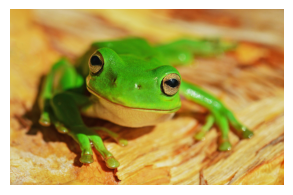

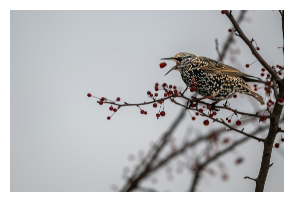

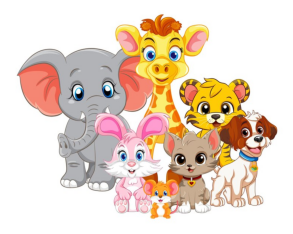

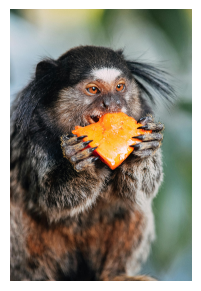

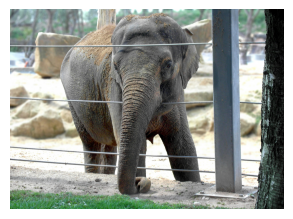

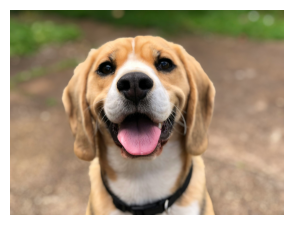

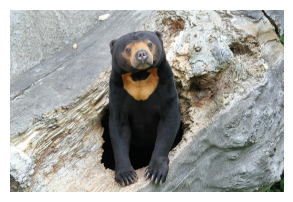

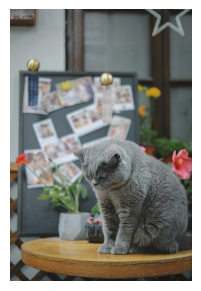

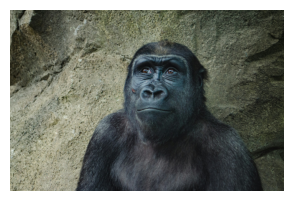

In [53]:
from glob import glob
import random
import matplotlib.pyplot as plt
import os
import cv2
train_img = os.path.join(train_dir, '**', '*.jpg')
images = glob(train_img)
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB));
    plt.axis('off')
plt.show()

**Preparing Data for Training**

In [112]:
img_size = 48
batch_size = 6
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(horizontal_flip = True)
datagen_train = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train. flow_from_directory("/content/Animal Emotion/train",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

validation_generator = datagen_train.flow_from_directory("/content/Animal Emotion/validation",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 54 images belonging to 3 classes.
Found 14 images belonging to 3 classes.


**Defining model**

In [113]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [114]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [115]:
def model_fer(input_shape, num_classes):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,64,(3,3))
    conv_2 = Convolution(conv_1,128,(5,5))
    conv_3 = Convolution(conv_2,256,(3,3))
    conv_4 = Convolution(conv_3,512,(3,3))

    flatten = Flatten()(conv_4)

    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(dense_1,512)

    output  = Dense(num_classes, activation="softmax")(dense_2)
    model  =  Model(inputs=[inputs],outputs = [output])

    opt = Adam(learning_rate=0.0005)

    model.compile(loss='categorical_crossentropy' , optimizer = opt , metrics =['accuracy'])

    return model

In [116]:
num_classes = 3
model = model_fer((48,48,1), num_classes)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_66 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_66 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_66 (Dropout)        (None, 24, 24, 64)        0  

**Intializing the model**

In [117]:
epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor =0.1, patience = 2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stop]

In [111]:
print("Number of samples in train_generator:", train_generator.n)


Number of samples in train_generator: 54


**Training the model**

In [118]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.6133 - accuracy: 0.3704
Epoch 1: saving model to model.weights.h5
9/9 [==============================] - 28s 3s/step - loss: 1.6133 - accuracy: 0.3704 - val_loss: 1.0843 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.3275 - accuracy: 0.3704
Epoch 2: saving model to model.weights.h5
9/9 [==============================] - 23s 3s/step - loss: 1.3275 - accuracy: 0.3704 - val_loss: 1.1086 - val_accuracy: 0.4167 - lr: 5.0000e-04
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.3466 - accuracy: 0.3519
Epoch 3: saving model to model.weights.h5
9/9 [==============================] - 22s 2s/step - loss: 1.3466 - accuracy: 0.3519 - val_loss: 1.0486 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 1.2520 - accuracy: 0.3704
Epoch 4: saving model to model.weights.h5
9/9 [===========================

**Model Evaluation**

In [119]:
model.evaluate(validation_generator)

3/3 [==============================] - 4s 1s/step - loss: 1.0876 - accuracy: 0.4286


[1.08755362033844, 0.4285714328289032]

**Plotting loss**

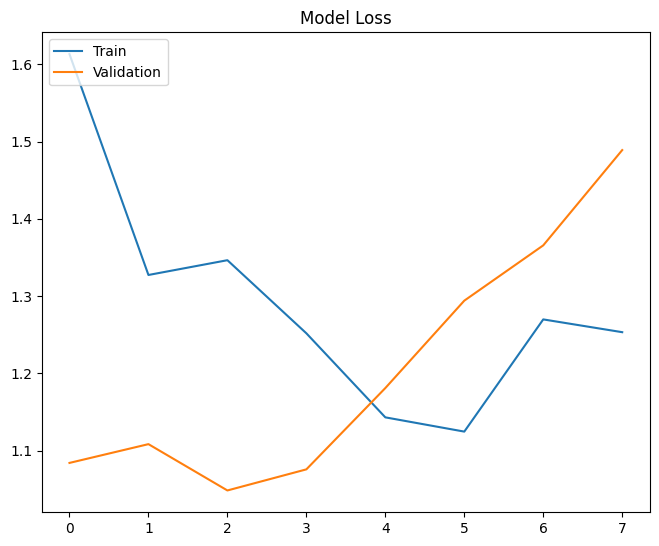

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

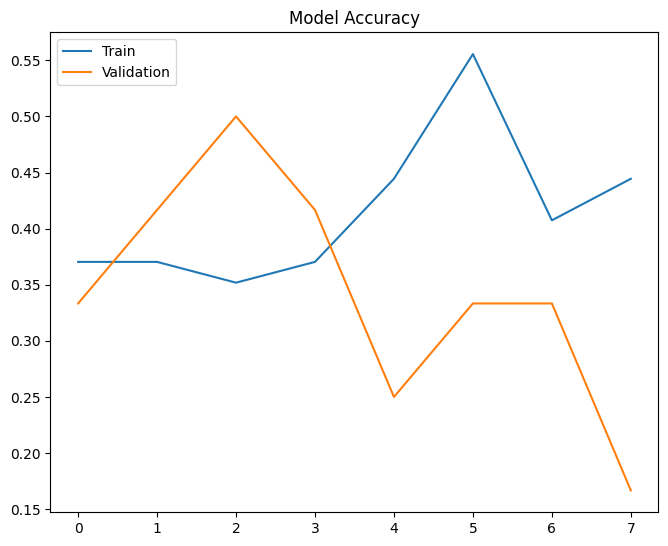

In [121]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

**Saving Model**

In [122]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)

**Uploading files**

In [123]:
from google.colab import files
uploaded = files.upload()

Saving gui.py to gui.py
Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default.xml


In [124]:
!ls

'Animal Emotion'   gui.py				 model_a.json	    sample_data
 drive		   haarcascade_frontalface_default.xml	 model.weights.h5


In [ ]:
import os
import tkinter as tk
from tkinter import filedialog, Label, Button
from tkinter import *

from sklearn import metrics

from tensorflow.keras.models import model_from_json
from PIL import Image, ImageTk
import numpy as numpy
import cv2

def FacialExpressionModel(json_file, weights_file):
  loaded_model_json = None
  with open(json_file,"r") as file:
        loaded_model_json = file.read()
        model = model_from_json(loaded_model_json)
        model.load_weights(weights_file)
        model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

        return model

!apt-get install -y xvfb
!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 600))
display.start()

json_file = "model_a.json"
weights_file = "model.weights.h5"
weights_path = os.path.abspath(weights_file)
model = FacialExpressionModel(json_file, weights_path)

top= tk.Tk()
top.geometry('800x600')
top.title('Animal Emotion Detector')
top.configure(background='#CDCDCD')

label1 = Label(top, background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)

facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model_a.json", "model.weights.h5")


EMOTIONS_LIST = ["Happy","Sad","Hungry"]
ANIMALS_LIST = ["Dog", "Cat", "Cow", "Giraffe", "Elephant", "Lion", "Pigeon", "Dolphin", "Duck", "Mouse", "Goat", "Parrot", "Monkey"]

def Detect(file_path):
    global Label_packed

    image = cv2.imread(file_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = facec.detectMultiScale(gray_image,1.3,5)
    try:
        for (x,y,w,h) in faces:
            fc = gray_image[y:y+h,x:x+w]
            roi = cv2.resize(fc,(48,48))
            roi = roi.astype('float') / 255.0
            roi = np.asarray(roi)
            roi = np.expand_dims(roi, axis=0)
            roi = np.expand_dims(roi, axis=-1)
            pred_emotion = EMOTIONS_LIST[np.argmax(model.predict(roi[np.newaxis,:,:,np.newaxis]))]
            pred_animal = ANIMALS_LIST[np.argmax(model.predict(roi[np.newaxis,:,:,np.newaxis]))]
        results.append(f"{pred_animal}: {pred_emotion}")
        label1.configure(foreground="#011638",text = pred)
    except:
        label1.configure(foreground="#011638",text = "Unable to detect")

def show_Detect_button(file_path):
    detect_b = Button(top,text="Detect Emotion", command= lambda: Detect(file_path),padx=10,pady=5)
    detect_b.configure(background="#364156",foreground='white',font=('arial',10,'bold'))
    detect_b.place(relx =0.79,rely=0.46)
    pass


def upload_image():
    try:
        file_path = filedialog.askopenfilename()
        uploaded = Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.3),(top.winfo_height()/2.3)))
        im = ImageTk.PhotoImage(uploaded)

        sign_image.configure(image = im)
        sign_image.image = im
        label1.configure(text = '')
        show_Detect_button(file_path)
    except:
        pass

upload = Button(top,text = "Upload Image", command = upload_image,padx=10,pady=5)
upload.configure(background="#364156",foreground='white',font=('arial',20,'bold'))
upload.pack(side='bottom',pady=50)
sign_image.pack(side='bottom',expand='True')
label1.pack(side='bottom',expand='True')
heading = Label(top,text='Emotion Detector',pady=20,font=('arial',25,'bold'))
heading.configure(background='#CDCDCD',foreground="#364156")
heading.pack()

top.mainloop()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
